## Gaussian Processes

This notebook walks through the steps needed to reproduce the GP trainings and reproduce the results/visualisations. GPJax is used as framework for the training.

#### Setup

Importing relevant modules and custom scripts. A number of helper functions are also defined to clean up experiment code.

In [4]:
import os
import paths
import torch
import datetime

import numpy as np
import pandas as pd
import optax as ox
import jax.random as jr
import jax.numpy as jnp
import matplotlib.dates as mdt
import matplotlib.ticker as mtk
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp

from tqdm import tqdm
from jax import jit, config
from train_model import load_data, train
from apollo import mechanics as ma
from jaxtyping import install_import_hook
from docs.examples.utils import clean_legend
from sklearn.preprocessing import StandardScaler
from preprocessing import catchment_characteristics as cc

key = jr.key(123)
config.update("jax_enable_x64", True)
with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
    
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", message="findfont: Font family")

C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [5]:
def retrieve_prior(kernel):
    meanf = gpx.mean_functions.Zero()
    return gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [6]:
def plot_sample(rf, prior, year=2000, cols=['cadetblue', 'darkKhaki'], save_path=None):
    
    rf_sel = rf[pd.to_datetime(rf['Date']).dt.year.isin([year])]
    trnset, full_set = load_data.preprocess_data(rf_sel, features, years_eval, years_train)

    xspace = ma.featurelocator(rf, features)
    x_train = load_data.reshape_input(full_set, xspace)
    date_list = rf_sel['Date'].apply(lambda timestamp: pd.to_datetime(timestamp, unit='s'))
    prior_dist = prior.predict(x_train)

    # Distillate the mean and variance to be able to sample functions
    prior_mean, prior_std = prior_dist.mean(), prior_dist.variance()
    samples = prior_dist.sample(seed=key, sample_shape=(5,))
    
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(date_list, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
    ax.plot(date_list, prior_mean, color=cols[1], label="Prior mean")
    ax.fill_between(date_list, prior_mean - prior_std, prior_mean + prior_std, alpha=0.3,
        color=cols[1], label="Prior variance")
    ax.legend(loc="best")
    ax.set_ylabel('Flow (m'+r'$^3$'+'s'+r'$^{-1}$'+')')
    ax.xaxis.set_major_locator(mdt.MonthLocator())
    ax.xaxis.set_major_formatter(mdt.DateFormatter('%b'))
    ax = clean_legend(ax)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

In [28]:
def plot_gp_results(rf, year, plot_confidence=True, colour1='darkKhaki', colour2='Teal', ax=None, plot_labels=True, title=''):
    cols = ['cadetblue', 'darkseagreen']

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    
    rf_year = rf[pd.to_datetime(rf['Date']).dt.year.isin([year])]
    pred_mean = rf_year['Predicted']
    pred_std = rf_year['Predicted_std']
    y_test = rf_year['Flow']

    if plot_confidence is True:
        ax.fill_between(
            rf_year['Date'], 
            pred_mean.squeeze() - 2 * pred_std.squeeze(),
            pred_mean.squeeze() + 2 * pred_std.squeeze(),
            alpha=0.2,
            label="Two sigma",
            color=cols[1],
        )
        ax.plot(
            rf_year['Date'], 
            pred_mean - 2 * pred_std,
            linestyle="--",
            linewidth=0.5,
            color=cols[1],
        )
        ax.plot(
            rf_year['Date'], 
            pred_mean + 2 * pred_std,
            linestyle="--",
            linewidth=0.5,
            color=cols[1],
        )
    ax.plot(
        rf_year['Date'],  y_test, label="Observations", color=colour1, alpha=0.95, lw=1.5,
        ls='--'
    )
    # Add a horizontal line at 0
    ax.axhline(y=0, color='white', linestyle='-', linewidth=1)    
    ax.fill_between(rf_year['Date'], y1=pred_mean.min()-2*pred_std.max(), y2=0, color='white', alpha=0.75)
    
    ax.plot(rf_year['Date'],  pred_mean, label="Predictive mean", color=colour2, lw=1.5)
    ax.xaxis.set_major_locator(mdt.MonthLocator())
    ax.xaxis.set_major_formatter(mdt.DateFormatter('%b'))
    if plot_labels is True:
        #ax.set_ylabel('Flow (m'+r'$^3$'+'s'+r'$^{-1}$'+')')
        ax.legend(loc="upper right", fontsize=12)
    ax.set_xlabel(title, fontweight='bold', fontsize=12)
    ax.set_ylim(0, max(y_test) * 1.8)
    ax.grid(c='black', ls='dotted', lw=0.5)
    
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.tick_params(axis='both', labelsize=12)

In [18]:
def plot_lengthscales(df, save_path, bar_width = 0.30):

    fig, ax = plt.subplots(figsize=(14, 5))
    bar_positions = np.arange(len(df['Feature']))

    bars1 = ax.bar(bar_positions - bar_width/2, df['Lengthscale_1'], width=bar_width, alpha=0.8, color='teal', label='Lengthscale Matern32')
    bars2 = ax.bar(bar_positions + bar_width/2, df['Lengthscale_2'], width=bar_width, alpha=0.4, color='cadetblue', label='Lengthscale Exponential')

    ax.set_ylabel('Lengthscale', fontweight='bold', fontsize=12)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(df['Feature'], rotation=45, ha='right', fontsize=12)
    ax.legend(fontsize=12)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

### Experiment Variables

All variables that could be modified during the experiments. The features refer to the type of input variables that will be used for training and how many days in the past are included. Similar data processing as the Neural Networks (see ANN_replication.ipynb). Data retrieved from NRFA (input parameters) and the NRFA website (target flow values) is retrieved and preprocessed so it can be used for training.

In [9]:
station = 33039

days = 6
features = (['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] \
            +['Snow Melt'] + ['Snow Melt-' + f'{d+1}' for d in range(days)] \
            + ['Temperature'] + ['Temperature-' + f'{d+1}' for d in range(days)] \
            + ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu','Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']
            )

years_train = [1981 + i for i in range(30)]
years_eval = [2010 + i for i in range(12)]

input_type = '9to9_surf_interp' #others: {'linear', '9to9_cubic', '9to9_surf_interp' ...}

tfb = tfp.bijectors
num_inducing_points = 120
dimensions = np.arange(len(features)).tolist()

schedule = ox.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=0.01,
    warmup_steps=100,
    decay_steps=2000,
    end_value=0.001,
)

#### Loading and Processing Relevant Data

Data loading function that extracts and preprocesses the data as defined in the “Experiment Variables” section and returns the in- and output for training. For reproduction, also the river streamflow can be obtained from the *https://nrfa.ceh.ac.uk/* website, and the meteorological input variables through the Coopernicus CDS API, *https://cds.climate.copernicus.eu/*. The input variables are preprocessed in the correct manner after running 'assembly.py'. 

In [10]:
# In- and output variables
original_data = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + f"_lumped_{input_type}.csv"))
original_data['Date'] = pd.to_datetime(original_data['Date'], format='%Y-%m-%d').dt.date
subset = ['Flow'] + ['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] + ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu']
clean_data = original_data.dropna(subset=subset)
print(len(original_data) - len(clean_data), 'riverflow values are missing.')

149 riverflow values are missing.


#### Running Experiments

Data is extracted and preprocessed as defined in the "Experiment Variables" section. We use Gaussian Processes with the hyperparameters as described above. The paper outlines which metrics generate the best performances for each latitude. Our three metrics (RMSE, NSE, RE) are then calculated.

In [11]:
def get_GP_model(Dataset, xfull, prior, N_inducing_points, N_dim):
    
    # Choice for the value of obs_stddev (POSTERIOR)
    likelihood = gpx.likelihoods.Gaussian(num_datapoints=Dataset.n, obs_stddev=jnp.array([1.0], dtype=jnp.float64)) 
    likelihood = likelihood.replace_bijector(obs_stddev=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64)))
    posterior = prior * likelihood
    
    # Initialize the inducing points for the SSVI (randomly distributed along the range of each dimension)
    inducing_points = [jr.uniform(key, shape=(N_inducing_points,), 
                                  minval= np.min(xfull, axis=0)[i], 
                                  maxval= np.max(xfull, axis=0)[i]) for i in range(N_dim)]
    z = jnp.stack(inducing_points, axis=-1)
    return gpx.variational_families.VariationalGaussian(posterior=posterior, inducing_inputs=z)

In [12]:
def train_GP_with_SSVI(rf, years_train, years_eval, prior, batch_size, learning_rate=schedule, N_inducing_points=num_inducing_points, features=features):

    # LOAD DATA
    trnset, full_set = load_data.preprocess_data(rf.copy(), features, years_eval, years_train)
    targets = ['Flow']
    xspace = ma.featurelocator(rf, features)
    yspace = ma.featurelocator(rf, targets)

    x_train = load_data.reshape_input(trnset, xspace)
    y_train = load_data.reshape_output(trnset, yspace)   

    y_scaler = StandardScaler().fit(y_train)
    standardised_train_y = y_scaler.transform(y_train)
    
    xfull = load_data.reshape_input(full_set, xspace)
    print(x_train.shape)
        
    D = gpx.Dataset(X=jnp.array(x_train, dtype=jnp.float64), y=jnp.array(standardised_train_y, dtype=jnp.float64))

    model = get_GP_model(D, xfull, prior, N_inducing_points, len(features))
    negative_elbo = gpx.objectives.ELBO(negative=True)
    negative_elbo = jit(negative_elbo)

    opt_posterior, history = gpx.fit(
        model=model,
        objective=negative_elbo,
        train_data=D,
        optim=ox.adam(learning_rate=learning_rate),
        num_iters=3000,
        key=jr.key(42),
        batch_size=batch_size,
    )
    
    # EVALUATION
    rf = rf.reset_index(drop=True)
    rf_test = rf[pd.to_datetime(rf['Date']).dt.year.isin(years_eval)]
    test_set = full_set[rf_test.index]
    xtest = load_data.reshape_input(test_set, xspace)
    ytest = load_data.reshape_output(test_set, yspace)
    standardised_test_y = y_scaler.transform(ytest)
    
    latent_dist = opt_posterior(xtest)
    predictive_dist = opt_posterior.posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean().reshape(-1, 1)
    predictive_std = predictive_dist.stddev().reshape(-1, 1)
    
    rf_test['Predicted'] = y_scaler.inverse_transform(predictive_mean)
    rf_test['Predicted_std'] = y_scaler.inverse_transform(predictive_std)
    rf_test['Groundtruth'] = y_scaler.inverse_transform(np.array(standardised_test_y).reshape(-1,1))
    
    #rf_test['Date'] =  pd.to_datetime(rf_test['Date'], unit='s')
    #rf_test = rf_test[rf_test['Date'].dt.year.isin(years_train + years_eval)]
    rf_test.reset_index(drop=True, inplace=True)
    return rf_test, opt_posterior

#### Experiment 1: Run Gaussian Process with SSVI

Running Gaussian processes with the SSVI-method, to reduce computation time and be able to include the full dataset (the algorithm will select the relevant 'inducing' points.

##### Prior (kernel design)

C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


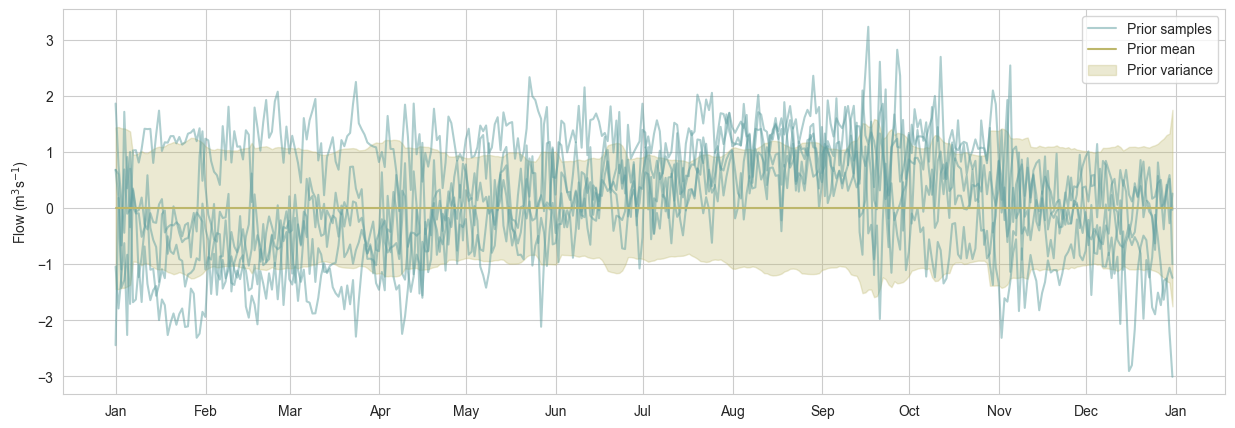

In [13]:
softclip_low = jnp.array(1e-5, dtype=jnp.float64)
softclip_high_var = jnp.array(1e4, dtype=jnp.float64)
softclip_high_ls = jnp.array(1e2, dtype=jnp.float64)

prior_lengthscales_mat = [ 5.77060686,  1.21959746,  0.69687078,  0.69898598,  0.90915178,
        1.49118433,  1.8841172 ,  3.29151727,  3.31919685,  2.48584073,
        2.98982897,  0.85619667,  0.68645478,  1.56625746,  1.24220438,
        1.25901404, 12.78878634,  0.4554342 ,  9.59251603, 15.27193089,
        7.96883918,  8.46118772,  8.77741858,  9.2091376 ,  9.57999859,
        9.49083195,  9.29341385]
prior_lengthscales_mat = [2.0] * len(features)
lengthscale_array_mat = jnp.array(prior_lengthscales_mat, dtype=jnp.float64)

prior_lengthscales_exp = [4.78632419,  1.25084178, 1.13585625,  1.17697819,  1.55530478,  2.06918453, 2.45088506, 3.06352494,  2.70962021,  1.78062854,  2.24130439,  0.92588557, 1.11351423,  1.67553362, 2.84994813,  2.49523691,  9.8908335,   1.16673449, 8.53591838, 13.72344582,  7.21963418,  7.70819113,  8.15077465,  8.31105174, 8.05947438,  8.02494786,  7.66610265]
prior_lengthscales_exp = [2.0] * len(features)
lengthscale_array_exp = jnp.array(prior_lengthscales_exp, dtype=jnp.float64)

kernel_Matern = gpx.kernels.Matern32(active_dims=dimensions, lengthscale=lengthscale_array_mat, variance=0.09)
kernel_Matern = kernel_Matern.replace_bijector(lengthscale=tfb.SoftClip(low=softclip_low, high=softclip_high_ls), 
                                               variance=tfb.SoftClip(low=jnp.array(1e-4, dtype=jnp.float64), 
                                                                     high=softclip_high_var))

kernel_Linear = gpx.kernels.Linear(active_dims=dimensions, variance=0.4)
kernel_Linear = kernel_Linear.replace_bijector(variance=tfb.SoftClip(low=jnp.array(1e-4, dtype=jnp.float64),
                                                                     high=softclip_high_var))

kernel_exp = gpx.kernels.PoweredExponential(active_dims=dimensions, lengthscale=lengthscale_array_exp, variance=0.61)
kernel_exp = kernel_exp.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-5, dtype=jnp.float64)),
                                         variance=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), 
                                                               high=jnp.array(1e4, dtype=jnp.float64)))

# Define Rational Quadratic kernel for capturing varying smoothness
kernel_RationalQuadratic = gpx.kernels.RationalQuadratic(active_dims=dimensions, lengthscale=lengthscale_array_mat, variance=1.0, alpha=1.0)
kernel_RationalQuadratic = kernel_RationalQuadratic.replace_bijector(lengthscale=tfb.SoftClip(low=softclip_low, 
                                                                                              high=softclip_high_ls),
                                                                     variance=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), 
                                                                                           high=softclip_high_var))

# White Noise kernel with a lower initial variance
kernel_WhiteNoise = gpx.kernels.White(active_dims=dimensions, variance=0.005)
kernel_WhiteNoise = kernel_WhiteNoise.replace_bijector(variance=tfb.SoftClip(low=jnp.array(1e-8, dtype=jnp.float64), high=jnp.array(1e4, dtype=jnp.float64)))

product_kernel = gpx.kernels.ProductKernel(kernels=[kernel_Matern, kernel_Linear])
kernel = gpx.kernels.SumKernel(kernels=[product_kernel, kernel_exp, kernel_WhiteNoise])

###############################

prior = retrieve_prior(kernel)
plot_sample(clean_data.copy(), prior, save_path=f"{paths.IMAGES}/GP_prior_samples.png")

#### Creating posterior & training

In [14]:
rf_predicted, opt_posterior = train_GP_with_SSVI(rf = clean_data.copy(), 
                                                 years_train=years_train, 
                                                 years_eval=years_eval, 
                                                 prior=prior, 
                                                 batch_size=128, 
                                                 learning_rate=schedule, 
                                                 N_inducing_points=num_inducing_points, 
                                                 features=features)

(10834, 27)


  0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [15]:
def get_posterior_info(opt_posterior):
    kernels = opt_posterior.posterior.prior.kernel.kernels

    kernel_data = []
    for kernel in kernels:
        lengthscale = getattr(kernel, 'lengthscale', None)
        if lengthscale is not None and len(lengthscale) > 1:
            lengthscale_dict = dict(zip(features, lengthscale))
        else:
            lengthscale_dict = lengthscale
        variance = round(kernel.variance,3)        
        kernel_info = {
            'name': kernel.name,
            'lengthscale': lengthscale_dict, 
            'variance': variance
         }
        kernel_data.append(kernel_info)
        
    return pd.DataFrame(kernel_data)
get_posterior_info(opt_posterior)

,name,lengthscale,variance
0,Matérn32,"{'Rain': 7.559042811738834, 'Rain-1': 2.116095...",0.256
1,Linear,None,0.305
2,Powered Exponential,"{'Rain': 3.7421840323823767, 'Rain-1': 1.74074...",0.01
3,White,None,0.001


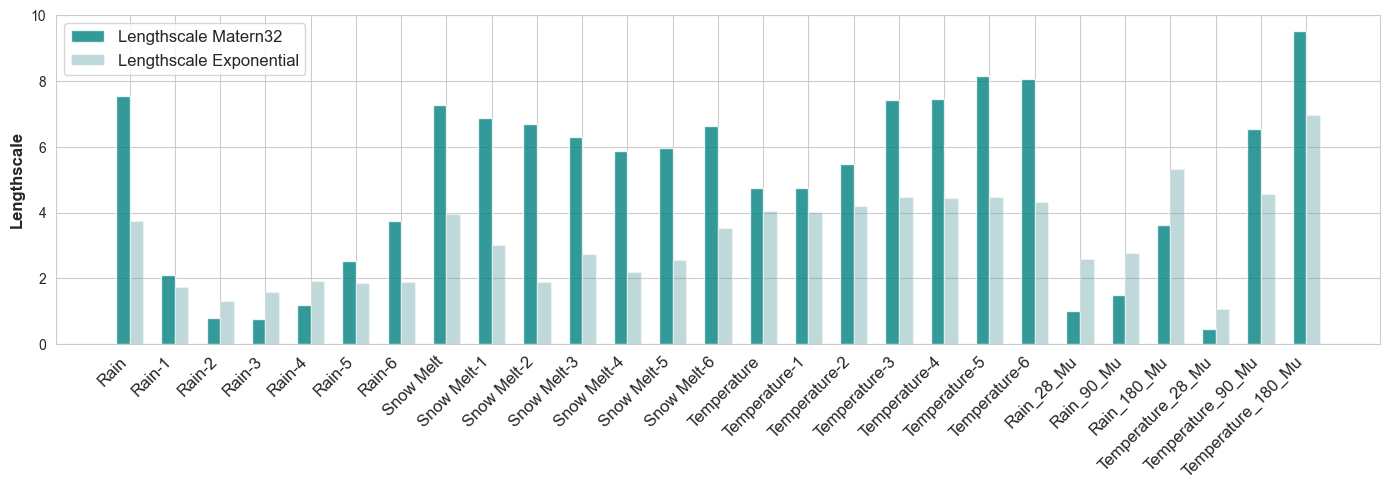

In [19]:
lengthscales_1 = opt_posterior.posterior.prior.kernel.kernels[0].lengthscale
lengthscales_2 = opt_posterior.posterior.prior.kernel.kernels[2].lengthscale
df = pd.DataFrame({'Feature': features, 'Lengthscale_1': lengthscales_1, 'Lengthscale_2': lengthscales_2})
    
plot_lengthscales(df, save_path=f"{paths.IMAGES}/GP_lengthscales.png")

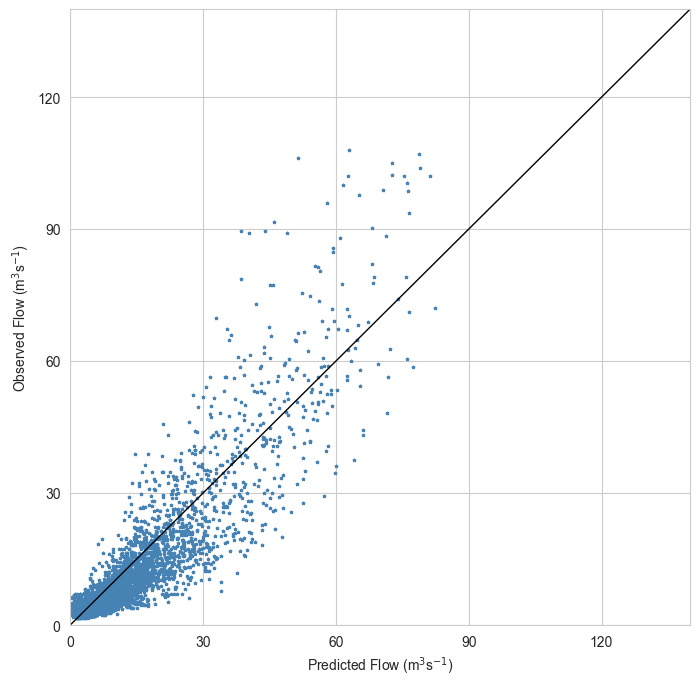

RMSE: 6.6078731648688676
NSE: 0.7806696691733235
RE: 0.9318597820721785


In [17]:
# Plot the network performance
for test_period in ([years_eval]):
     
    rf_predicted = rf_predicted.dropna()
    rf_predicted['Date'] = pd.to_datetime(rf_predicted['Date'])
    performance_dict = train.calculate_performance_metrics(rf_predicted, test_period) 

    print('RMSE: ' + str(performance_dict.get('RMSE')))
    print('NSE: ' + str(performance_dict.get('NSE')))
    print('RE: ' + str(performance_dict.get('RE')))

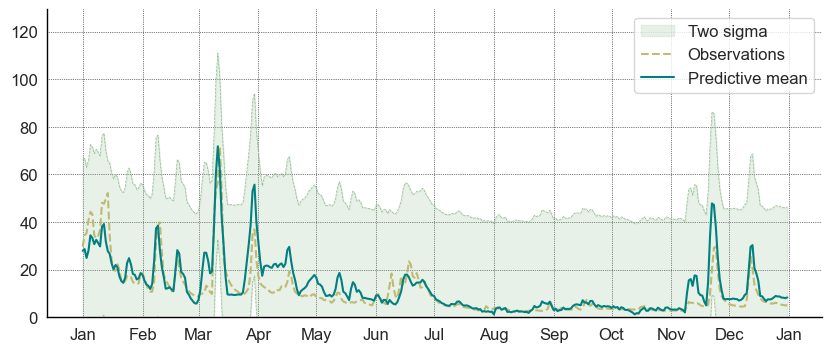

In [29]:
plot_gp_results(rf_predicted, 2016)

In [30]:
outdf

,Unnamed: 0.1,Unnamed: 0,Date,Flow,Temperature,U Windspeed,V Windspeed,Humidity,Snow Melt,Resultant Windspeed,...,Rain-24,Rain-25,Rain-26,Rain-27,Rain_28_Mu,Rain_90_Mu,Rain_180_Mu,Predicted,Predicted_std,Groundtruth
0,11084,11323,2010-01-01,31.570,273.936697,0.362176,-1.910614,96.933760,2.287504e-05,1.944638,...,2.786193,0.271513,1.275376,3.776221,1.589177,2.953447,3.616425,NaN,NaN,31.570
1,11085,11324,2010-01-02,31.090,272.486572,-1.858274,-1.939703,87.720758,5.204170e-15,2.686193,...,0.568758,2.786193,0.271513,1.275376,1.479609,2.947813,3.535283,NaN,NaN,31.090
2,11086,11325,2010-01-03,29.810,270.914395,1.219634,1.402654,95.399291,5.204170e-15,1.858748,...,0.011757,0.568758,2.786193,0.271513,1.445605,2.889125,3.522914,NaN,NaN,29.810
3,11087,11326,2010-01-04,28.670,274.228584,1.651035,1.178237,89.523940,5.204170e-15,2.028339,...,0.003548,0.011757,0.568758,2.786193,1.536655,2.917060,3.525623,NaN,NaN,28.670
4,11088,11327,2010-01-05,30.240,273.273962,-0.077199,-3.755390,94.533019,5.204170e-15,3.756183,...,0.003037,0.003548,0.011757,0.568758,1.555275,2.938597,3.535601,NaN,NaN,30.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4378,15462,15701,2021-12-27,6.629,278.783492,-0.496029,1.618723,95.908229,5.622091e-02,1.693018,...,7.810849,1.410732,1.574056,8.794388,2.772629,3.178256,2.893295,NaN,NaN,6.629
4379,15463,15702,2021-12-28,8.270,278.013985,0.233542,0.743381,100.357242,5.096919e-03,0.779203,...,9.415367,7.810849,1.410732,1.574056,2.466163,3.142550,2.894490,NaN,NaN,8.270
4380,15464,15703,2021-12-29,27.620,279.755516,-2.302576,2.796058,91.132859,8.875687e-01,3.622125,...,1.880263,9.415367,7.810849,1.410732,2.802780,3.222646,2.953948,NaN,NaN,27.620
4381,15465,15704,2021-12-30,40.830,285.346902,3.526217,3.450855,92.228020,0.000000e+00,4.933823,...,0.964235,1.880263,9.415367,7.810849,2.789702,3.189136,2.921225,NaN,NaN,40.830


149 riverflow values are missing.
(10957, 27)


  0%|          | 0/3000 [00:00<?, ?it/s]

149 riverflow values are missing.
(10957, 27)


  0%|          | 0/3000 [00:00<?, ?it/s]

149 riverflow values are missing.
(10957, 27)


  0%|          | 0/3000 [00:00<?, ?it/s]

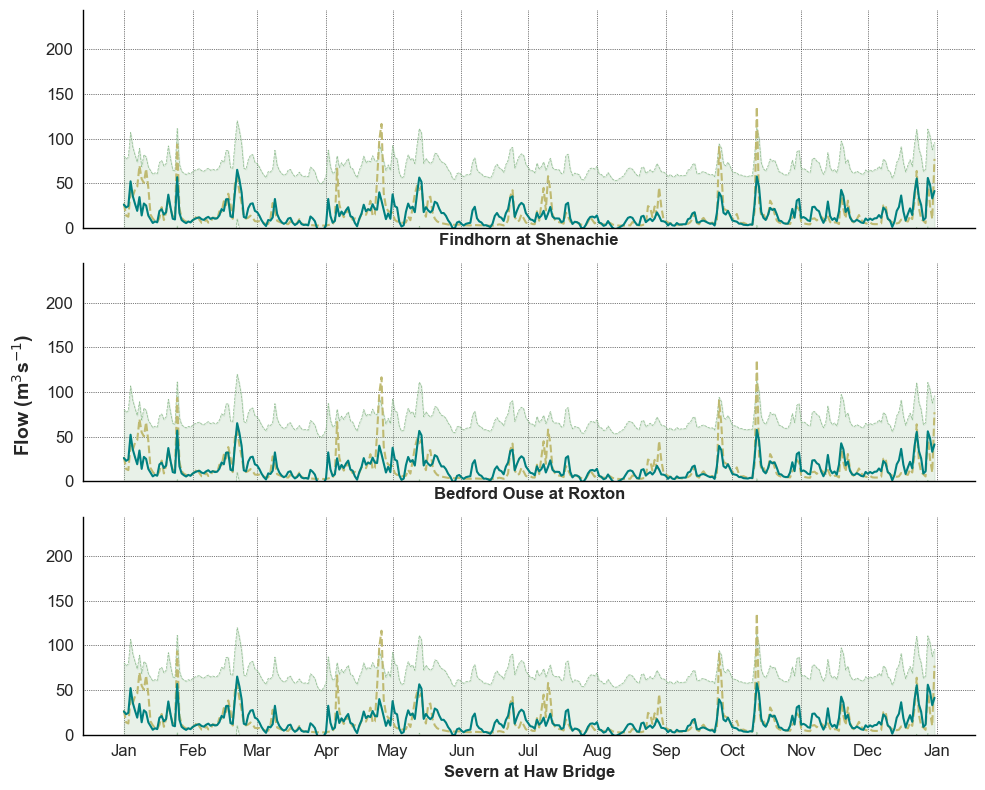

In [31]:
# PLOT performance for 1 year across the 3 most important sites
stations = ['7001', '33039', '54057']
titles = ['Findhorn at Shenachie', 'Bedford Ouse at Roxton', 'Severn at Haw Bridge']

fig, ax = plt.subplots(len(stations), figsize=(10, 8), sharex=True)
year = 2012

for i, station in enumerate(stations):
    
    ooriginal_data = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + f"_lumped_{input_type}.csv"))
    original_data['Date'] = pd.to_datetime(original_data['Date'], format='%Y-%m-%d').dt.date
    subset = ['Flow'] + ['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] + ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu']
    clean_data = original_data.dropna(subset=subset)
    print(len(original_data) - len(clean_data), 'riverflow values are missing.')
    
    outdf, _ = train_GP_with_SSVI(rf = clean_data.copy(), 
                                                 years_train=years_train, 
                                                 years_eval=years_eval, 
                                                 prior=prior, 
                                                 batch_size=128, 
                                                 learning_rate=schedule, 
                                                 N_inducing_points=num_inducing_points, 
                                                 features=features)
    if i == len(stations):
        plot_gp_results(outdf, year=year, ax=ax[i], plot_labels=True, title=titles[i])
    else:
        plot_gp_results(outdf, year=year, ax=ax[i], plot_labels=False, title=titles[i])

# Labeling the y-axis
fig.supylabel('Flow (m' + r'$^3$' + 's' + r'$^{-1}$' + ')', weight='bold', size=14)

# Spacing
plt.tight_layout()
plt.savefig(f'{paths.IMAGES}/stacked_GP_performances.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
## MODEL TRAINING + PREDICTIONS

input_type = '9to9_linear'
days = 6

for station_nr in tqdm(os.listdir('../' + paths.CATCHMENT_BASINS), desc="Processing Stations"):
    print(station_nr)
    out_path = '../' + paths.PREDICTIONS + f"/{input_type}_GP/{station_nr}_{input_type}_GP.csv"
    
    if not os.path.exists(out_path+'_'):
    
        original_data = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + f"_lumped_{input_type}.csv"))
        original_data['Date'] = pd.to_datetime(original_data['Date'], format='%Y-%m-%d').dt.date
        clean_data = original_data.dropna(subset=['Flow'])
    
        outdf, _ = train_GP_with_SSVI(rf = clean_data.copy(), 
                                                 years_train=years_train, 
                                                 years_eval=years_eval, 
                                                 prior=prior, 
                                                 batch_size=128, 
                                                 learning_rate=schedule, 
                                                 N_inducing_points=num_inducing_points, 
                                                 features=features)
        outdf.to_csv(out_path)
        

Processing Stations:   0%|          | 0/26 [00:00<?, ?it/s]

12003
(10957, 27)


  0%|          | 0/3000 [00:00<?, ?it/s]

Processing Stations:   4%|▍         | 1/26 [06:58<2:54:33, 418.96s/it]

18002
(10957, 27)


  0%|          | 0/3000 [00:00<?, ?it/s]

Processing Stations:   8%|▊         | 2/26 [11:48<2:17:03, 342.63s/it]

22001
(10840, 27)


  0%|          | 0/3000 [00:00<?, ?it/s]

Processing Stations:  12%|█▏        | 3/26 [14:48<1:42:54, 268.44s/it]

27007
(10923, 27)


  0%|          | 0/3000 [00:00<?, ?it/s]

In [50]:
overview_era5_snow_gdf = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS, 
                                                   input_type='9to9_linear_Snow')
overview_nrfa_snow_gdf = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS, 
                                                   input_type='9to9_nrfa_Snow')
overview_gp_snow_gdf = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS, 
                                                   input_type='9to9_linear_GP')

comparison = overview_era5_snow_gdf.merge(overview_nrfa_snow_gdf[['Station', 'NSE']], on='Station')
comparison = comparison.rename(columns={'NSE_x':'NSE_Era5', 'NSE_y':'NSE_NRFA'})

comparison_snow = overview_era5_snow_gdf.merge(overview_gp_snow_gdf[['Station', 'NSE']], on='Station')
comparison_snow = comparison_snow.rename(columns={'NSE_x':'NSE_Era5_snow', 'NSE_y':'NSE_NRFA_snow'})

comparison = comparison_snow.merge(comparison[['Station', 'NSE_Era5', 'NSE_NRFA']], on='Station')

comparison['model_difference'] = comparison['NSE_NRFA'] - comparison['NSE_Era5']

In [52]:
comparison

,Station,Name,NSE_Era5_snow,HE_mean,Geometry,Cross_distance,Area,Minimum altitude,Maximum altitude,Height difference,Slope gradient,90 percentile,Latitude,NSE_NRFA_snow,NSE_Era5,NSE_NRFA,model_difference
0,34004,Wensum at Costessey Mill,0.729809,7.355162,POLYGON ((617650.0000999998 312775.00009999983...,45340.960678,5.596969e+08,5.3,96.1,90.8,0.002003,71.1,52.764986,0.582359,0.729809,0.823979,0.094170
1,33035,Ely Ouse at Denver Complex,0.702345,4.081698,POLYGON ((558925.0000999998 300975.00009999983...,100027.393447,3.580786e+09,-1.3,165.5,166.8,0.001668,84.9,52.323534,0.582359,0.702345,0.796259,0.093914
2,33039,Bedford Ouse at Roxton,0.796852,6.871104,POLYGON ((516025.00009999983 253525.0000999998...,56953.026939,1.662298e+09,4.7,247.3,242.6,0.004260,137.3,52.048438,0.582359,0.796852,0.914394,0.117542
3,53018,Avon at Bathford,0.856052,11.964156,POLYGON ((378525.00009999983 167025.0000999998...,61972.410938,1.569351e+09,20.3,304.6,284.3,0.004588,172.1,51.396097,0.582359,0.856052,0.948919,0.092867
4,39072,Thames at Royal Windsor Park,0.853589,8.382862,"POLYGON ((498075 177200, 498075 177150, 497975...",114591.428687,7.125187e+09,17.5,330.2,312.7,0.002729,187.4,51.656695,0.582359,0.853589,0.942618,0.089029
5,39016,Kennet at Theale,0.770423,9.071790,POLYGON ((464975.00009999983 170850.0000999998...,58522.762341,1.037387e+09,44.6,295.7,251.1,0.004291,205.2,51.431400,0.582359,0.770423,0.917630,0.147207
6,39008,Thames at Eynsham,0.887524,9.484268,POLYGON ((444525.00009999983 208700.0000999998...,50100.269767,1.626782e+09,60.0,330.2,270.2,0.005393,222.7,51.741075,0.582359,0.887524,0.923358,0.035835
7,28022,Trent at North Muskham,0.875886,11.286190,POLYGON ((480475.00009999983 360525.0000999998...,114485.169064,8.209420e+09,4.8,635.5,630.7,0.005509,260.2,52.846081,0.582359,0.875886,0.935137,0.059251
8,28009,Trent at Colwick,0.874532,11.796661,POLYGON ((462075.00009999983 339925.0000999998...,116679.585459,7.466409e+09,17.5,635.5,618.0,0.005297,273.7,52.832833,0.582359,0.874532,0.944446,0.069915
9,54057,Severn at Haw Bridge,0.854694,11.967990,POLYGON ((384500.00009999983 227875.0000999998...,178976.469825,9.885468e+09,7.4,826.2,818.8,0.004575,303.5,52.458711,0.582359,0.854694,0.916485,0.061791


C:\Users\aline\AppData\Local\Temp\ipykernel_26440\2894257689.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(latitude_labels, rotation=45, fontsize=12)


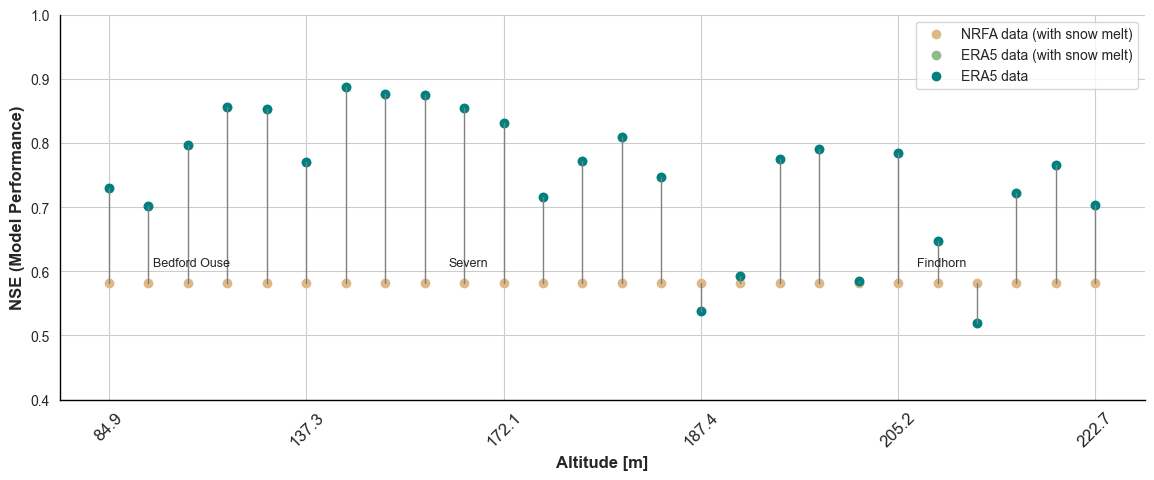

In [51]:
# Sort Dataframe by latitude
sort_param = '90 percentile'
comparison = comparison.sort_values(by=sort_param).reset_index(drop=True)
latitude_labels = [round(value, 2) for value in comparison[sort_param]]

catchment_dict ={'7001':'Findhorn',
                 '33039':'Bedford Ouse',
                 '54057':'Severn'}

fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot NSE values for Era5 and NRFA as dots
ax1.scatter(comparison.index, comparison['NSE_NRFA_snow'], color='BurlyWood', label='NRFA data (with snow melt)')
ax1.scatter(comparison.index, comparison['NSE_Era5_snow'], color='darkseagreen', label='ERA5 data (with snow melt)')
ax1.scatter(comparison.index, comparison['NSE_Era5'], color='Teal', label='ERA5 data')

# Draw lines between each pair of dots
for i in range(len(comparison)):
    ax1.plot([i, i], [comparison['NSE_Era5'].iloc[i], comparison['NSE_NRFA_snow'].iloc[i]], color='gray', linestyle='-', linewidth=1)
    
# Add station names next to the focus catchments
param = 'NSE_NRFA_snow'
for j, row in comparison.iterrows():
    if row['Station'] in ['7001','33039','54057']:
        x_offset = 0.1
        y_offset = 0.025
        ax1.text(j + x_offset, row[param] + y_offset, catchment_dict.get(row['Station']), fontsize=9, ha='center')

# Labels and title for the first axis
ax1.set_xlabel('Altitude [m]', fontweight='bold', fontsize=12)
ax1.set_ylabel('NSE')
ax1.set_xticklabels(latitude_labels, rotation=45, fontsize=12)
ax1.set_ylim(0.4,1)
ax1.set_ylabel('NSE (Model Performance)', fontweight='bold', fontsize=12)
ax1.legend(loc='upper right')

ax1.spines['bottom'].set_linewidth(1)
ax1.spines['left'].set_linewidth(1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')

plt.grid(True)
plt.savefig(f"{paths.IMAGES}/nrfa_vs_era5_modelperformance.png", dpi=300, bbox_inches='tight')
plt.show()